# 머신 러닝을 위한 텍스트 전처리
## 1. One-Hot 인코딩
- 분류, 회귀 등 다양한 문제를 해결하기 위해 텍스트 데이터를 훈련시키기 위해서는 keras 모델이 받아들일 수 있는 형태인 넘파이 텐서 형태로 데이터를 변환해야 한다.
- 다양한 방법 중 하나인 One-Hot 인코딩은 각각의 단어 또는 문자마다 인덱스를 할당하여 해당 인덱스에 binary 형식으로 존재 유무를 표기하는 방식이다. 구현이 쉽고 간단하지만, 텐서의 대부분이 비어 있어 비효율적이라는 것이 단점이다.
- 단어 수준의 One-Hot 인코딩은 아래와 같이 구현해 볼 수 있다.

In [2]:
import numpy as np

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

token_index = {}
for sample in samples:
    for word in sample.split():
        if word not in token_index:
            token_index[word] = len(token_index) + 1
max_length = 10

results = np.zeros(shape=(len(samples), max_length,
                   max(token_index.values()) + 1))

for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i, j, index] = 1.


- 단어보다 더 작은 단위인 문자 수준으로 One-Hot 인코딩을 진행할 경우, 각 문자별로 인덱스를 할당하여 존재 여부를 표시하면 된다.

In [3]:
import string
samples = ['The cat sat on the mat.', 'The dog ate my homework.']
characters = string.printable
token_index = dict(zip(characters, range(1, len(characters) + 1)))

max_length = 50
results = np.zeros((len(samples), max_length, max(token_index.values()) + 1))
for i, sample in enumerate(samples):
    for j, character in enumerate(sample):
        index = token_index.get(character)
        results[i, j, index] = 1.

- 고유한 토큰의 수가 너무 커서 모두 다루기 어려울 때는 Hashing을 활용하여 One-Hot 인코딩을 위한 인덱스를 생성하는 방법도 있다. 다만 이 방법을 사용하면 해쉬 테이블의 크기가 토큰의 양을 감당할 수 없을 경우 정확도가 떨어질 수 있다.

In [4]:
samples = ['The cat sat on the mat.', 'The dog ate my homework.', 
'Out of the night comes a man who saves lives at the risk of his own. Once a circus performer, an aerialist who refused the net. Once a cat burglar, a master among jewel thieves. Now a professional bodyguard. Primitive... savage... in love with danger. The Cat!']

dimensionality = 1000
max_length = 100

results = np.zeros((len(samples), max_length, dimensionality))

dic = {}

for i, words in enumerate(samples):
    for j, word in enumerate(words.split()[:max_length]):
        index = abs(hash(word)) % dimensionality
        dic[index] = word
        results[i, j, index] = 1.


for i in results:
    string = ''
    result = ''
    for j in i:
        index = 0
        for k in j:
            if not (k == 0):
                string += str(index) + ' '
                result += dic[index] + ' '
            index += 1
    print(string)
    print(result)

126 117 984 437 755 546 
The cat sat on the mat. 
126 179 408 782 186 
The dog ate my homework. 
393 234 755 341 217 279 665 651 393 287 200 755 868 234 888 412 152 279 731 751 861 653 651 230 755 371 152 279 117 716 279 688 405 630 95 415 279 538 169 111 85 633 369 947 732 126 161 
saves of the night comes a man who saves lives at the risk of his own. Once a circus performer, an aerialist who refused the net. Once a cat burglar, a master among jewel thieves. Now a professional bodyguard. Primitive... savage... in love with danger. The Cat! 


## 2. 단어 Embedding 벡터 사용하기
- One-Hot 인코딩으로 만든 벡터는 sparse하고 고차원인데 반해, 상대적으로 저차원의 실수형 벡터 방식으로 단어와 벡터를 연관 지을 수 있는 Embedding 방법을 사용해 보자.
- One-Hot 인코딩과는 달리, Embedding 벡터는 데이터로부터 학습된다. 같은 차원의 One Hot 인코딩보다 더 많은 정보를 저장할 수 있다는 장점이 있다.
- Keras에서는 Embedding 층을 활용하여 학습시킬 수 있으며, 다른 모델과 마찬가지로 사전에 훈련된 임베딩 벡터를 적용할 수도 있다.

In [5]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(1000, 64) # Params: (# of max tokens, dimension)

In [6]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras import preprocessing

max_features = 10000
maxlen = 20

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Embedding

model = Sequential()
model.add(Embedding(10000, 8, input_length=maxlen))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train, epochs = 10, batch_size=32, validation_split=0.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 8)             80000     
                                                                 
 flatten (Flatten)           (None, 160)               0         
                                                                 
 dense (Dense)               (None, 1)                 161       
                                                                 
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 6s 6ms/step - loss: 0.6658 - acc: 0.6285 - val_loss: 0.6122 - val_acc: 0.7012
Epoch 2/10
625/625 [==============================] - 4s 6ms/step - loss: 0.5370 - acc: 0.7524 - val_loss: 0.5237 - val_acc: 0.7336
Epoch 3/10
625/625 [==============================] 

- 사전 훈련된 Embedding 공간을 사용하여 IMDB 데이터를 학습한다.
  
- 케라스에 기본 탑재된 IMDB 데이터는 이미 각 단어별로 인덱스가 부여되어 있기 때문에, 토큰화 되어있지 않은 원본 데이터를 다운받아 사용한다. 링크: http://mng.bz/0tIo

In [8]:
import os

imdb_dir = '../datasets/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen = 100
training_samples = 200
validation_samples = 10000
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('%s개의 고유한 토큰을 찾았습니다.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('데이터 텐서의 크기:', data.shape)
print('레이블 텐서의 크기:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples].reshape((-1,1))

x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples].reshape((-1,1))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

88582개의 고유한 토큰을 찾았습니다.
데이터 텐서의 크기: (25000, 100)
레이블 텐서의 크기: (25000,)
(200, 100) (200, 1) (10000, 100) (10000, 1)


- 이미지 분류 문제에서 사전 훈련된 네트워크를 사용했던 것 처럼, https://nlp.stanford.edu/projects/glove 에서 사전 계산된 Embedding을 다운받아 사용한다.

In [10]:
glove_dir = '../datasets/'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('%s개의 단어 벡터를 찾았습니다.' % len(embeddings_index))

400000개의 단어 벡터를 찾았습니다.


In [11]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

- 10000개의 단어를 표현하기 위해 10000차원이 필요했던 One-Hot 인코딩과 달리, 사전 훈련된 임베딩을 활용하여 100차원만으로 단어에 대한 벡터를 구현할 수 있다.
- 케라스 모델을 구성하고 Embedding 층을 만든 뒤 미리 구축해놓은 임베딩 텐서를 가중치로 사용하고 훈련을 진행한다.

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [13]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 flatten_1 (Flatten)         (None, 10000)             0         
                                                                 
 dense_1 (Dense)             (None, 64)                640064    
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,644,289
Trainable params: 644,289
Non-trainable params: 1,000,000
_________________________________________________________________


In [14]:
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
7/7 [==============================] - 2s 276ms/step - loss: 1.0460 - acc: 0.5400 - val_loss: 0.8575 - val_acc: 0.4958
Epoch 2/10
7/7 [==============================] - 1s 185ms/step - loss: 0.7208 - acc: 0.5450 - val_loss: 0.6767 - val_acc: 0.5761
Epoch 3/10
7/7 [==============================] - 1s 175ms/step - loss: 0.5540 - acc: 0.7750 - val_loss: 1.0676 - val_acc: 0.4958
Epoch 4/10
7/7 [==============================] - 1s 169ms/step - loss: 0.5563 - acc: 0.7300 - val_loss: 1.0608 - val_acc: 0.5066
Epoch 5/10
7/7 [==============================] - 1s 185ms/step - loss: 0.2443 - acc: 0.9450 - val_loss: 0.6990 - val_acc: 0.5765
Epoch 6/10
7/7 [==============================] - 1s 187ms/step - loss: 0.1507 - acc: 0.9500 - val_loss: 1.1073 - val_acc: 0.5007
Epoch 7/10
7/7 [==============================] - 1s 228ms/step - loss: 0.2587 - acc: 0.8750 - val_loss: 0.9703 - val_acc: 0.5361
Epoch 8/10
7/7 [==============================] - 1s 219ms/step - loss: 0.0408 - acc: 1.00

## 3. 결과 분석
- 훈련 샘플 수가 적기 때문에 overfitting이 다소 빠르게 진행되고 검증 정확도와 훈련 정확도 사이의 차이가 크다. 훈련 샘플의 수가 적기 때문에, 어떤 훈련 샘플을 선택하느냐에 따라서 결과 역시 크게 달라질 것이다. 

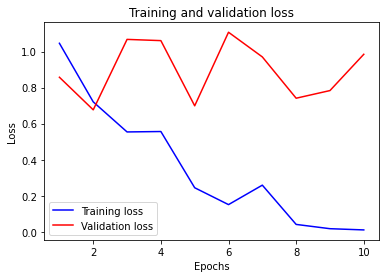

In [15]:
import matplotlib.pyplot as plt

history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training and validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

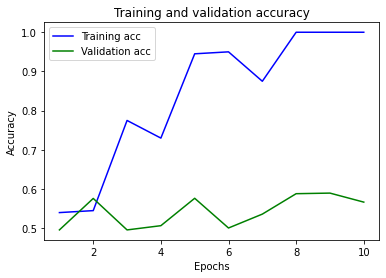

In [16]:
plt.clf()
acc = history_dict['acc']
val_acc = history_dict['val_acc']

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title("Training and validation accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

- 테스트 데이터에서 모델을 평가해본 결과 약 55%의 정확도가 나왔다. 훈련 샘플의 수를 늘리면 더 나은 결과를 얻을 수 있을 듯 하다.

In [17]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels).reshape((-1,1))
print(x_test.shape, y_test.shape)


(25000, 100) (25000, 1)


In [18]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

782/782 [==============================] - 5s 6ms/step - loss: 1.0204 - acc: 0.5566


[1.020403504371643, 0.5565599799156189]